# Running runup models
In this notebook, we combine tidal, wave and slope data obtained in the previous notebooks to calculate wave runup on the beach. We use the py-wave-runup tool coded by:

> Chris Leaman, Tomas Beuzen, & Evan B. Goldstein. (2020). chrisleaman/py-wave-runup: v0.1.10 (v0.1.10). Zenodo. https://doi.org/10.5281/zenodo.3629949

In [1]:
# Import the libraries needed
from py_wave_runup import models
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from scipy.stats import percentileofscore
import numpy as np
np.float = float #This is for compatibility of the py-wave-runup library

## Import data

First, we import wave, tidal and slope data calculated in the previous steps.

In [2]:
from coastsat.CsatVe_select_folder import select_folder
# Call the function to select a folder and create additional folders for Waves
sitename_container = select_folder(create_additional_folders=True)
sitename = sitename_container["value"]
if sitename:
    print(f"The selected folder name is: {sitename}")
else:
    print("No folder was selected.")

No folder was selected.


In [3]:
sitename = sitename_container["value"]
# Define folders where data and images will be saved
outdata_path = os.path.join("Data", sitename, "Runup","data")
images_path = os.path.join("Data", sitename, "Runup","img")

## Import data
Now, we load the data saved in the previous steps, and show the first rows to make sure there are no errors.

In [4]:
# Load wave data
waves = pd.read_csv(os.path.join('Data',sitename,'Waves','data','GLOBAL_REANALYSIS_WAV_001_032_waves_all.csv'), parse_dates=['time'])
waves['time'] = pd.to_datetime(waves['time'], format='%Y-%m-%d %H:%M:%S',utc=True)
waves

,time,VHM0,VTPK,VMDR
0,2000-01-01 00:00:00+00:00,1.26,4.58,20.25
1,2000-01-01 03:00:00+00:00,1.23,5.19,28.86
2,2000-01-01 06:00:00+00:00,1.24,5.39,25.95
3,2000-01-01 09:00:00+00:00,1.26,4.73,198.46
4,2000-01-01 12:00:00+00:00,1.15,4.78,166.28
...,...,...,...,...
68163,2023-04-30 09:00:00+00:00,1.53,11.25,202.98
68164,2023-04-30 12:00:00+00:00,1.64,11.47,178.42
68165,2023-04-30 15:00:00+00:00,1.80,11.75,170.72
68166,2023-04-30 18:00:00+00:00,1.88,11.78,167.47


In [5]:
#Load tide data
tides = pd.read_csv(os.path.join('Data',sitename,'water_levels',f'FES2022_tides_{sitename}.csv'), parse_dates=['dates'])
tides['dates'] = pd.to_datetime(tides['dates'], format='%Y-%m-%d %H:%M:%S.%f+00:00')
tides

,dates,tide
0,2000-01-01 00:00:00+00:00,-0.287
1,2000-01-01 00:10:00+00:00,-0.132
2,2000-01-01 00:20:00+00:00,0.025
3,2000-01-01 00:30:00+00:00,0.183
4,2000-01-01 00:40:00+00:00,0.340
...,...,...
1306076,2024-10-30 23:20:00+00:00,-1.144
1306077,2024-10-30 23:30:00+00:00,-1.252
1306078,2024-10-30 23:40:00+00:00,-1.351
1306079,2024-10-30 23:50:00+00:00,-1.442


In [6]:
#Load slope data
slope = pd.read_csv(os.path.join('Data',sitename,'slope_estimation','slopes.csv'))
slope

,Transect,CI_Lower,CI_Upper,Slope
0,1,0.0710,0.0810,0.076
1,2,0.0635,0.0760,0.071
2,3,0.0685,0.0810,0.076
3,4,0.0810,0.0910,0.086
4,5,0.0710,0.0860,0.076
5,6,0.0785,0.0885,0.081


### Modern wave runup

First, we calculate runup for all waves with direction perpendicular to the coast. To each calculated runup, we add the corresponding tidal level. 

For which concerns slope, we sample random slopes from the frequency distributions of the slopes extracted for each transect from CoastSat.slope.

### Coupling wave and tidal data
First, we couple the waves and tide data by their timestamps.

In [7]:
# Sort both dataframes by the 'date' columns
waves.sort_values('time', inplace=True)
tides.sort_values('dates', inplace=True)
# Merge the dataframes based on the closest date and time
df = pd.merge_asof(waves, tides, left_on='time', right_on='dates', direction='nearest')
# Calculate the time difference in minutes and format the column
df['time_diff'] = ((df['time'] - df['dates']).dt.total_seconds() / 60).round(2)
waves_tides=df.copy()

waves_tides

,time,VHM0,VTPK,VMDR,dates,tide,time_diff
0,2000-01-01 00:00:00+00:00,1.26,4.58,20.25,2000-01-01 00:00:00+00:00,-0.287,0.0
1,2000-01-01 03:00:00+00:00,1.23,5.19,28.86,2000-01-01 03:00:00+00:00,1.835,0.0
2,2000-01-01 06:00:00+00:00,1.24,5.39,25.95,2000-01-01 06:00:00+00:00,0.253,0.0
3,2000-01-01 09:00:00+00:00,1.26,4.73,198.46,2000-01-01 09:00:00+00:00,-1.908,0.0
4,2000-01-01 12:00:00+00:00,1.15,4.78,166.28,2000-01-01 12:00:00+00:00,-0.706,0.0
...,...,...,...,...,...,...,...
68163,2023-04-30 09:00:00+00:00,1.53,11.25,202.98,2023-04-30 09:00:00+00:00,-1.121,0.0
68164,2023-04-30 12:00:00+00:00,1.64,11.47,178.42,2023-04-30 12:00:00+00:00,-0.233,0.0
68165,2023-04-30 15:00:00+00:00,1.80,11.75,170.72,2023-04-30 15:00:00+00:00,1.316,0.0
68166,2023-04-30 18:00:00+00:00,1.88,11.78,167.47,2023-04-30 18:00:00+00:00,0.335,0.0


### Slope calculation

We then calculate a probabilistic distribution (`random.triangular` sampling) of slope values from the 5-95% confidence intervals extracted from CoastSat.slope, and plot the results. 


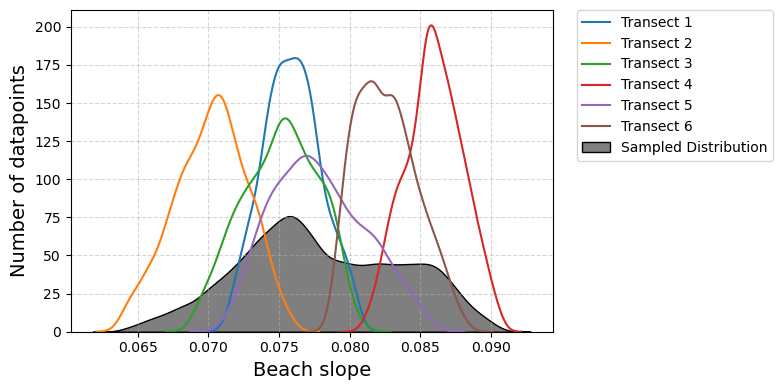

In [8]:
from coastsat.CsatVe_beach_slope import generate_random_samples,beach_slope_plot
# Seed for repeatability
random_seed = 42
np.random.seed(random_seed)
# Generate the random sample dataframe
random_samples_df = generate_random_samples(slope, len(waves_tides), seed=random_seed)
# Call the updated plotting function
beach_slope_plot(slope, random_samples_df,images_path)

### Calculate runup
We then use py-wave-runup to calculate runup with different models. Note that Beuzen et al. was not implemented here because of an incompatibility betweeen the environment of CoastSat.Venice and that of the code of Beuzen et al.

In [9]:
# Inputs
VHM0 = waves_tides['VHM0'].tolist()
VTPK = waves_tides['VTPK'].tolist()
tide = waves_tides['tide'].tolist()

runup = {'Stockdon et al. (2006)': (models.Stockdon2006(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Vousdoukas et al. (2012)': (models.Vousdoukas2012(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Holman (1986)': (models.Holman1986(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Nielsen (2009)': (models.Nielsen2009(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Ruggiero et al. (2001)': (models.Ruggiero2001(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Atkinson et al. (2017)': (models.Atkinson2017(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Senechal et al. (2011)': (models.Senechal2011(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).R2+tide,
        'Passarella et al. (2018)': (models.Passarella2018(Hs=VHM0, Tp=VTPK, beta=random_samples_df.Sampled_Value)).swash+tide}

# Create dataframe of runup values
R2 = pd.DataFrame(runup)
R2 = pd.merge(R2, waves_tides, left_index=True, right_index=True)
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)']

## Filter and plot runup values

We then filter the runup values by angle and select only those above sea level (those that contribute to building the berms on the foreshore area).

In [10]:
# Change wave angles to keep only shore-perpendicular waves
min_wave_angle=30
max_wave_angle=150

# filtering waves with direction perpendicular to the coast
R2_filter = R2[(R2['VMDR'] >= min_wave_angle) & (R2['VMDR'] <= max_wave_angle)]
R2_filter = R2_filter[(R2_filter['tide'] > 0)]

R2_filter.reset_index(drop=True, inplace=True)

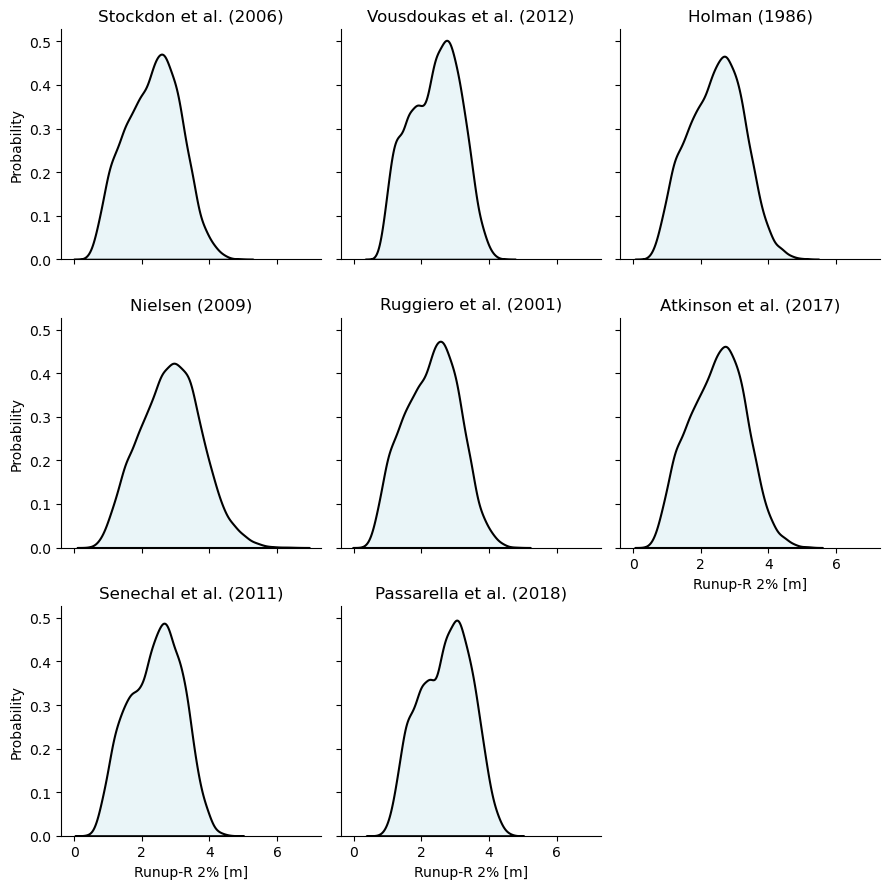

In [11]:
# Create FacetGrid object
grid = sns.FacetGrid(R2_filter.melt(value_vars=columns), col="variable", col_wrap=3, height=3)

# Plot KDE distributions with filled areas
grid.map(
    sns.kdeplot, 
    "value", 
    fill=True, 
    color="lightblue",  # Fill color
    edgecolor="k",  # KDE line color
    linewidth=1.5  # Line thickness
)

# Update titles and labels
for ax, col, title in zip(grid.axes.flat, columns, columns):
    ax.set_title(title)
    ax.set_xlabel('Runup-R 2% [m]')
    ax.set_ylabel('Probability')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(images_path, 'runup_modern_all.jpg'), dpi=500)
plt.show()

### Validate wave runup
To validate the runup models, we extract the model results for the time of survey, when we measured the elevation of the swash zone and the beach cusps, which are created by wave runup.

**If no data is available from the modern shoreline, this step can be skipped**

In [12]:
# Elevation of the instantaneous swash zone 
El1 = 0.55
El1_1s=0.30

# Time of survey
survey_date_time_str = '2019-11-02 15:55:41+00:00'

In [13]:
# Convert string to datetime object
survey_date_time = datetime.strptime(survey_date_time_str, '%Y-%m-%d %H:%M:%S%z')
# Remove timezone information to make it timezone-naive
survey_date_time = survey_date_time.replace(tzinfo=None)

# Assuming R2 is your DataFrame and it has a 'time' column with datetime objects
# Convert 'time' column to datetime if it's not already
R2['time'] = pd.to_datetime(R2['time']).dt.tz_localize(None)

# Find the row with the closest date and time
closest_datapoint = R2.loc[(R2['time'] - survey_date_time).abs().idxmin()]

# Save data to CSV file
closest_datapoint.to_csv(os.path.join(outdata_path, 'runup_survey_time.csv'), index=True)

closest_datapoint

Stockdon et al. (2006)                       0.403216
Vousdoukas et al. (2012)                     0.468425
Holman (1986)                                 0.53691
Nielsen (2009)                               0.847227
Ruggiero et al. (2001)                       0.360821
Atkinson et al. (2017)                       0.576296
Senechal et al. (2011)                       0.461461
Passarella et al. (2018)                     0.883333
time                              2019-11-02 15:00:00
VHM0                                             1.36
VTPK                                             8.36
VMDR                                            27.09
dates                       2019-11-02 15:00:00+00:00
tide                                             -0.6
time_diff                                         0.0
Name: 57965, dtype: object

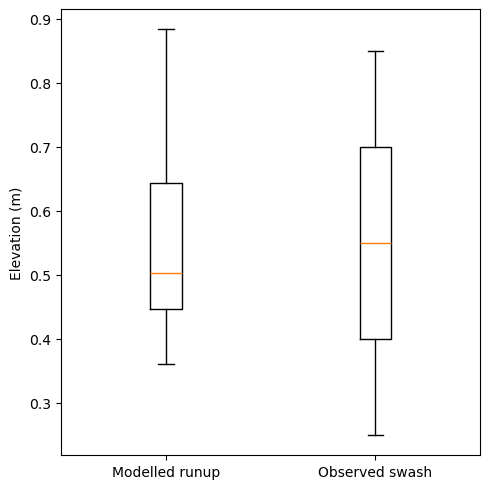

In [14]:
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)']
R2_values = closest_datapoint[columns].tolist()
# Combine the values with the swash zone data and 1-sigma range
combined_data = [R2_values, [El1 - El1_1s, El1 + El1_1s]]
# Plotting the box plot
plt.figure(figsize=(5, 5))
plt.boxplot(combined_data, tick_labels=['Modelled runup', 'Observed swash'], vert=True)
plt.ylabel('Elevation (m)')
plt.tight_layout()
plt.savefig(os.path.join(images_path,'benchmark_runup.jpg'),dpi=500)
plt.show()

The data is then saved

In [16]:
overall_data = R2_filter.melt(value_vars=columns)
overall_data.to_csv(os.path.join(outdata_path, 'runup_modern_total.csv'), index=True)

## Wave runup beyond the instrumental record

To calculate wave runup beyond the instrumental record, we need to assume that each wave condition in the instrumental record might have happened during different tidal stages, and that wave directions might have varied. Therefore we resample the waves and tides data to produce one million possible combinations.

First, we sample the slope. We plot the sampled slope and the original one to make sure they are equivalent.

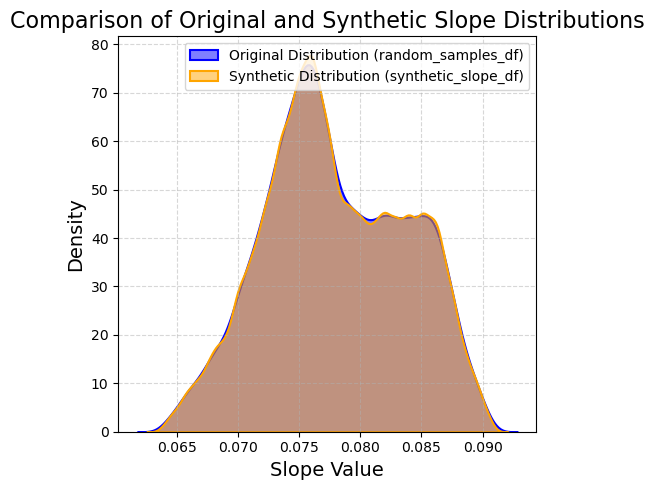

In [17]:
# NUmber of wave/tide conditions in the dataset
n=1000000

# Assuming random_samples_df is already defined
random_seed = 42
np.random.seed(random_seed)

# Generate synthetic slopes
synthetic_slopes = np.random.choice(random_samples_df['Sampled_Value'].values, size=1000000, replace=True)
synthetic_slope_df = pd.DataFrame({'Slope': synthetic_slopes})

# Plot the distribution of random_samples_df and synthetic_slope_df
plt.figure(figsize=(5, 5))

# KDE plot for random_samples_df
sns.kdeplot(
    random_samples_df['Sampled_Value'],
    fill=True,
    color="blue",
    alpha=0.5,
    linewidth=1.5,
    label="Original Distribution (random_samples_df)"
)

# KDE plot for synthetic_slope_df
sns.kdeplot(
    synthetic_slope_df['Slope'],
    fill=True,
    color="orange",
    alpha=0.5,
    linewidth=1.5,
    label="Synthetic Distribution (synthetic_slope_df)"
)

# Add title and labels
plt.title("Comparison of Original and Synthetic Slope Distributions", fontsize=16)
plt.xlabel("Slope Value", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()

Then, we produce a synthetic datasets of waves and tides. We only select tides above sea level, and we filter only the waves between the chosen angles. 

In [18]:
# filter waves and tides datasets
waves_filter= waves[(waves['VMDR'] >= min_wave_angle) & (waves['VMDR'] <= max_wave_angle)]
waves_filter.reset_index(drop=True, inplace=True)

tides_filter=tides[(tides['tide'] > 0)]
tides_filter.reset_index(drop=True, inplace=True)

# Create a synthetic wave/tide dataset
sampled_tides = tides_filter.sample(n=n, replace=True)
sampled_waves = waves_filter.sample(n=n, replace=True)

# Sample pairs of VHM0 and VTPK from waves_filter
sampled_waves = waves_filter[['VHM0', 'VTPK']].sample(n=n, replace=True, random_state=1).reset_index(drop=True)
# Sample tide values from tides_filter
sampled_tide = tides_filter['tide'].sample(n=n, replace=True, random_state=1).reset_index(drop=True)
# Combine the sampled data into a new dataframe
synth_ensamble = pd.concat([sampled_waves, sampled_tide], axis=1)

In [19]:
# Inputs
VHM0 = synth_ensamble['VHM0'].tolist()
VTPK = synth_ensamble['VTPK'].tolist()
tide = synth_ensamble['tide'].tolist()

runup = {'Stockdon et al. (2006)': (models.Stockdon2006(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Vousdoukas et al. (2012)': (models.Vousdoukas2012(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Holman (1986)': (models.Holman1986(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Nielsen (2009)': (models.Nielsen2009(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Ruggiero et al. (2001)': (models.Ruggiero2001(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Atkinson et al. (2017)': (models.Atkinson2017(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Senechal et al. (2011)': (models.Senechal2011(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).R2+tide,
        'Passarella et al. (2018)': (models.Passarella2018(Hs=VHM0, Tp=VTPK, beta=synthetic_slope_df.Slope)).swash+tide}

# Create dataframe of runup values
R2_synth = pd.DataFrame(runup)
columns = ['Stockdon et al. (2006)',
           'Vousdoukas et al. (2012)',
           'Holman (1986)',
           'Nielsen (2009)',
           'Ruggiero et al. (2001)',
           'Atkinson et al. (2017)',
           'Senechal et al. (2011)',
           'Passarella et al. (2018)']



## Plot modern and synthetic runup
The modern and sythetic runup are plotted on a two-panel plot.

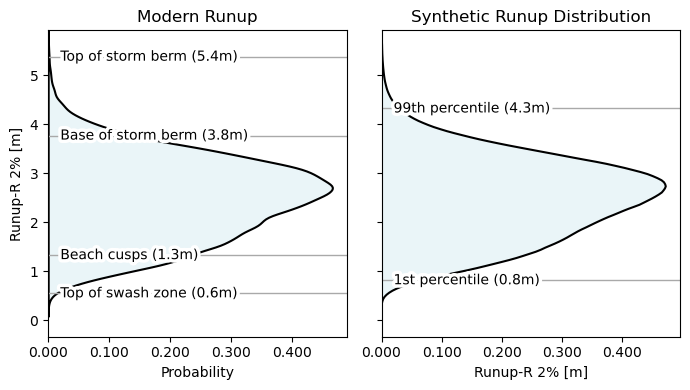

In [23]:
import matplotlib.patheffects as path_effects
from matplotlib.patheffects import withStroke

# Create a two-panel figure
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharey=True)  # Two panels side by side

# First Panel: Original KDE Plot
overall_data = R2_filter.melt(value_vars=columns)
Top_swash = 0.55
Beach_cusps = 1.33
Base_berm = 3.77
Top_berm = 5.38

sns.kdeplot(
    data=overall_data,
    y='value',
    fill=True,
    color="lightblue",
    linewidth=1.5,
    ax=axes[0],
    edgecolor='k'
)

axes[0].set_title('Modern Runup')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Runup-R 2% [m]')

key_points = [
    (Top_swash, f'Top of swash zone ({Top_swash:.1f}m)'),
    (Beach_cusps, f'Beach cusps ({Beach_cusps:.1f}m)'),
    (Base_berm, f'Base of storm berm ({Base_berm:.1f}m)'),
    (Top_berm, f'Top of storm berm ({Top_berm:.1f}m)'),
]

for y_value, label in key_points:
    axes[0].axhline(y_value, color='darkgray', linestyle='-', linewidth=1)
    text = axes[0].text(
        0.02, y_value, label, 
        color='k', fontsize=10, 
        verticalalignment='center', 
        horizontalalignment='left'
    )
    text.set_path_effects([
        path_effects.Stroke(linewidth=5, foreground="white"),
        path_effects.Normal()
    ])

axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

# Second Panel: Overall Synthetic Distribution
overall_synth = R2_synth.melt(value_vars=columns)
percentiles = overall_synth['value'].quantile([0.01,0.1,0.75, 0.99])

sns.kdeplot(
    data=overall_synth,
    y='value',
    fill=True,
    color="lightblue",
    linewidth=1.5,
    ax=axes[1],
    edgecolor='k'
)

axes[1].set_title('Synthetic Runup Distribution')
axes[1].set_xlabel('Runup-R 2% [m]')
axes[1].set_ylabel('Probability')

key_points = [
    (percentiles.iloc[0], f'1st percentile ({percentiles.iloc[0]:.1f}m)'),
    (percentiles.iloc[3], f'99th percentile ({percentiles.iloc[3]:.1f}m)'),
]

for y_value, label in key_points:
    axes[1].axhline(y_value, color='darkgray', linestyle='-', linewidth=1)
    text = axes[1].text(
        0.02, y_value, label, 
        color='k', fontsize=10, 
        verticalalignment='center', 
        horizontalalignment='left'
    )
    text.set_path_effects([
        path_effects.Stroke(linewidth=5, foreground="white"),
        path_effects.Normal()
    ])

axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

axes[0].set_ylim(None, Top_berm * 1.1)
axes[1].set_ylim(None, Top_berm * 1.1)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(images_path, 'two_panel_runup.jpg'), dpi=500)
plt.show()

In [24]:
overall_synth.to_csv(os.path.join(outdata_path, 'runup_synth_total.csv'), index=True)

## Acknowledgments
This code uses the FES2022 Tide product, funded by CNES, produced by LEGOS, NOVELTIS and CLS and made freely available by AVISO. CNES, 2024. FES2022 (Finite Element Solution) Ocean Tide (Version 2022) [Data set]. CNES. https://doi.org/10.24400/527896/A01-2024.004

- Carrere et al., OSTST 2022: A new barotropic tide model for global ocean: FES2022,
https://doi.org/10.24400/527896/a03-2022.3287

- Florent H. Lyard, Loren Carrere, Ergane Fouchet, Mathilde Cancet, David Greenberg, Gérald Dibarboure and Nicolas Picot: “FES2022 a step towards a SWOT-compliant tidal correction”, to be submitted to Ocean Sciences.

FES22 data are used herein under the terms of the [license agreement](https://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf)

Wave data in this code are generated using the E.U. Copernicus Marine Service Information. Data is available at this [link]( https://doi.org/10.48670/moi-00022). 

CoastSat.Venice was coded the framework of the WARMCOASTS project, led by A. Rovere at Ca' Foscari University of Venice. This software is part of a project that has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation programme (Grant agreement No. ERC-StG-802414)
